# Prediction Part

### What we'll do here
- Set up the environment and imports
- Load and prepare data
- Build preprocessing
- Train a prediction model
- Make predictions
- Evaluate performance
- Output figures

### How to run
1. Make sure you have the data in the data folder
2. Then run each subsequent step top-to-bottom.

### Table of Contents
- [2.1 Imports](#21-imports)
- [2.2 Load data](#22-load-data)
- [2.3 KMeans clustering (K=24)](#23-kmeans-clustering-k24)
- [2.4 Map the clusters](#24-map-the-clusters)
- [2.5 Elbow curve choice](#25-elbow-curve-choice)
- [2.6 Hourly series by cluster](#26-hourly-series-by-cluster)
- [2.7 Naive baseline](#27-naive-baseline)
- [2.8 Lag and calendar regression](#28-lag-and-calendar-regression)
- [2.9 Weekend-aware ridge](#29-weekend-aware-ridge)
- [2.10 24-hour rolling ridge](#210-24-hour-rolling-ridge)
- [2.11 Citywide demand prediction](#211-citywide-demand-prediction)
- [2.12 Citywide metrics](#212-citywide-metrics)
- [2.13 Cluster 21 rebalancing](#213-cluster-21-rebalancing)

### 2.1 Imports

Pull in the libraries and helper settings we use throughout the prediction workflow.


### 2.1 Imports

Pull in the libraries and helper settings we use throughout the prediction workflow.

In [23]:
# Core imports and randomness setup
import pandas as pd
from pathlib import Path
import numpy as np
from collections import Counter, defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import Counter
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from collections import deque

SEED = 42
import numpy as np  
np.random.seed(SEED)

### 2.2 Load data

Read the cleaned ride data and any saved outputs needed for clustering and modeling.

In [24]:
# Stream and clean raw trip files into typed hourly columns
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

DATA_PATH = Path("../data")
GLOB_PATTERN = "trips_2018.csv"
CHUNKSIZE = 250_000

USECOLS = [
    "tripduration","starttime","stoptime",
    "start_station_id","start_station_latitude","start_station_longitude",
    "end_station_id","end_station_latitude","end_station_longitude",
    "bikeid","usertype","birth_year","gender","Unnamed: 0",
]


def _iter_paths(path: Path):
    if path.is_file():
        yield path
    else:
        files = sorted(path.glob(GLOB_PATTERN))
        if not files:
            raise FileNotFoundError(f"No files found under {path} with pattern {GLOB_PATTERN}")
        for fp in files:
            yield fp


def clean_chunk(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=[c for c in ["Unnamed: 0"] if c in df.columns], errors="ignore")

    rename_map = {
        "starttime": "started_at",
        "stoptime": "ended_at",
        "start_station_id": "start_station_id",
        "end_station_id": "end_station_id",
        "start_station_latitude": "start_lat",
        "start_station_longitude": "start_lng",
        "end_station_latitude": "end_lat",
        "end_station_longitude": "end_lng",
    }
    df = df.rename(columns=rename_map)

    df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
    df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")
    df["hour_start"] = df["started_at"].dt.floor("h")
    df["hour_end"] = df["ended_at"].dt.floor("h")

    for col in ["start_station_id","end_station_id","bikeid","birth_year","gender","tripduration"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "start_station_id" in df: df["start_station_id"] = df["start_station_id"].astype("Int32")
    if "end_station_id" in df: df["end_station_id"] = df["end_station_id"].astype("Int32")
    if "bikeid" in df: df["bikeid"] = df["bikeid"].astype("Int32")
    if "birth_year" in df: df["birth_year"] = df["birth_year"].astype("Int16")
    if "gender" in df: df["gender"] = df["gender"].astype("Int8")
    if "tripduration" in df: df["tripduration"] = df["tripduration"].astype("Int32")

    for c in ["start_lat","start_lng","end_lat","end_lng"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")

    if {"start_lat","start_lng","end_lat","end_lng"}.issubset(df.columns):
        bad = (
            (df["start_lat"].abs() > 90) | (df["end_lat"].abs() > 90) |
            (df["start_lng"].abs() > 180) | (df["end_lng"].abs() > 180)
        )
        df = df.loc[~bad]

    if "usertype" in df.columns:
        df["usertype"] = df["usertype"].astype("category")

    cols = [
        "hour_start","hour_end","started_at","ended_at",
        "start_station_id","start_lat","start_lng",
        "end_station_id","end_lat","end_lng",
        "tripduration","bikeid","usertype","birth_year","gender",
    ]
    cols = [c for c in cols if c in df.columns]
    return df[cols]


def yield_clean_chunks():
    for fp in _iter_paths(DATA_PATH):
        print(f"Reading: {fp.name}")
        reader = pd.read_csv(fp, chunksize=CHUNKSIZE, low_memory=False, usecols=USECOLS)
        for raw in reader:
            yield clean_chunk(raw)


In [25]:
# Preview a single cleaned chunk to verify types and ranges
preview_reader = yield_clean_chunks()
cleaned_preview = next(preview_reader)
display(cleaned_preview.head(10))
display(cleaned_preview.dtypes)

Reading: trips_2018.csv


,hour_start,hour_end,started_at,ended_at,start_station_id,start_lat,start_lng,end_station_id,end_lat,end_lng,tripduration,bikeid,usertype,birth_year,gender
0,2018-01-01 13:00:00,2018-01-01 14:00:00,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767273,-73.993927,505,40.749012,-73.988487,970,31956,Subscriber,1992,1
1,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767273,-73.993927,3255,40.750584,-73.994682,723,32536,Subscriber,1969,1
2,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767273,-73.993927,525,40.755943,-74.002113,496,16069,Subscriber,1956,1
3,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767273,-73.993927,447,40.763706,-73.985161,306,31781,Subscriber,1974,1
4,2018-01-01 18:00:00,2018-01-01 18:00:00,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767273,-73.993927,3356,40.774666,-73.984703,306,30319,Subscriber,1992,1
5,2018-01-01 21:00:00,2018-01-01 21:00:00,2018-01-01 21:31:54.192,2018-01-01 21:58:36.353,72,40.767273,-73.993927,482,40.739357,-73.999321,1602,30106,Subscriber,1968,1
6,2018-01-02 07:00:00,2018-01-02 08:00:00,2018-01-02 07:54:53.646,2018-01-02 08:06:55.872,72,40.767273,-73.993927,228,40.754601,-73.971878,722,32059,Subscriber,1978,1
7,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:06:14.331,2018-01-02 08:13:28.767,72,40.767273,-73.993927,173,40.760685,-73.984528,434,30525,Subscriber,1983,1
8,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:10:15.255,2018-01-02 08:16:21.896,72,40.767273,-73.993927,479,40.760193,-73.991257,366,27439,Subscriber,1974,1
9,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:13:30.896,2018-01-02 08:18:55.120,72,40.767273,-73.993927,450,40.762272,-73.987885,324,30892,Subscriber,1947,1


hour_start          datetime64[ns]
hour_end            datetime64[ns]
started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id             Int32
start_lat                  float32
start_lng                  float32
end_station_id               Int32
end_lat                    float32
end_lng                    float32
tripduration                 Int32
bikeid                       Int32
usertype                  category
birth_year                   Int16
gender                        Int8
dtype: object

### 2.3 KMeans clustering (K=24)

Run KMeans to group pickup locations into 24 clusters so we can model demand by area.

In [26]:
# Build station master table from most frequent coordinates per station
coord_counts = defaultdict(Counter)
n_chunks = 0

for chunk in yield_clean_chunks():
    n_chunks += 1

    s = chunk[["start_station_id","start_lat","start_lng"]].dropna()
    if not s.empty:
        for sid, lat, lng in s.itertuples(index=False):
            coord_counts[int(sid)][(float(lat), float(lng))] += 1

    e = chunk[["end_station_id","end_lat","end_lng"]].dropna()
    if not e.empty:
        for sid, lat, lng in e.itertuples(index=False):
            coord_counts[int(sid)][(float(lat), float(lng))] += 1

    if n_chunks % 10 == 0:
        print(f"  processed {n_chunks} chunks... stations so far: {len(coord_counts)}")

rows = []
for sid, ctr in coord_counts.items():
    (lat, lon), _ = ctr.most_common(1)[0]
    rows.append((sid, lat, lon))

station_master = pd.DataFrame(rows, columns=["station_id","lat","lon"])
station_master["station_id"] = station_master["station_id"].astype("Int32")
station_master[["lat","lon"]] = station_master[["lat","lon"]].astype("float32")

K = 24
km = KMeans(n_clusters=K, n_init=10, random_state=42)
labels = km.fit_predict(station_master[["lat","lon"]].to_numpy())

cluster_map = station_master[["station_id"]].copy()
cluster_map["cluster_id"] = labels.astype(np.int32)

TABLES = Path("./TABLES"); TABLES.mkdir(exist_ok=True)
cluster_map_path = TABLES / "cluster_map.csv"
cluster_map.to_csv(cluster_map_path, index=False)


Reading: trips_2018.csv
  processed 10 chunks... stations so far: 781
  processed 20 chunks... stations so far: 804
  processed 30 chunks... stations so far: 816
  processed 40 chunks... stations so far: 829
  processed 50 chunks... stations so far: 837
  processed 60 chunks... stations so far: 841
  processed 70 chunks... stations so far: 850


### 2.4 Map the clusters

Visualize the clusters on a map to sanity-check that the grouping looks reasonable.

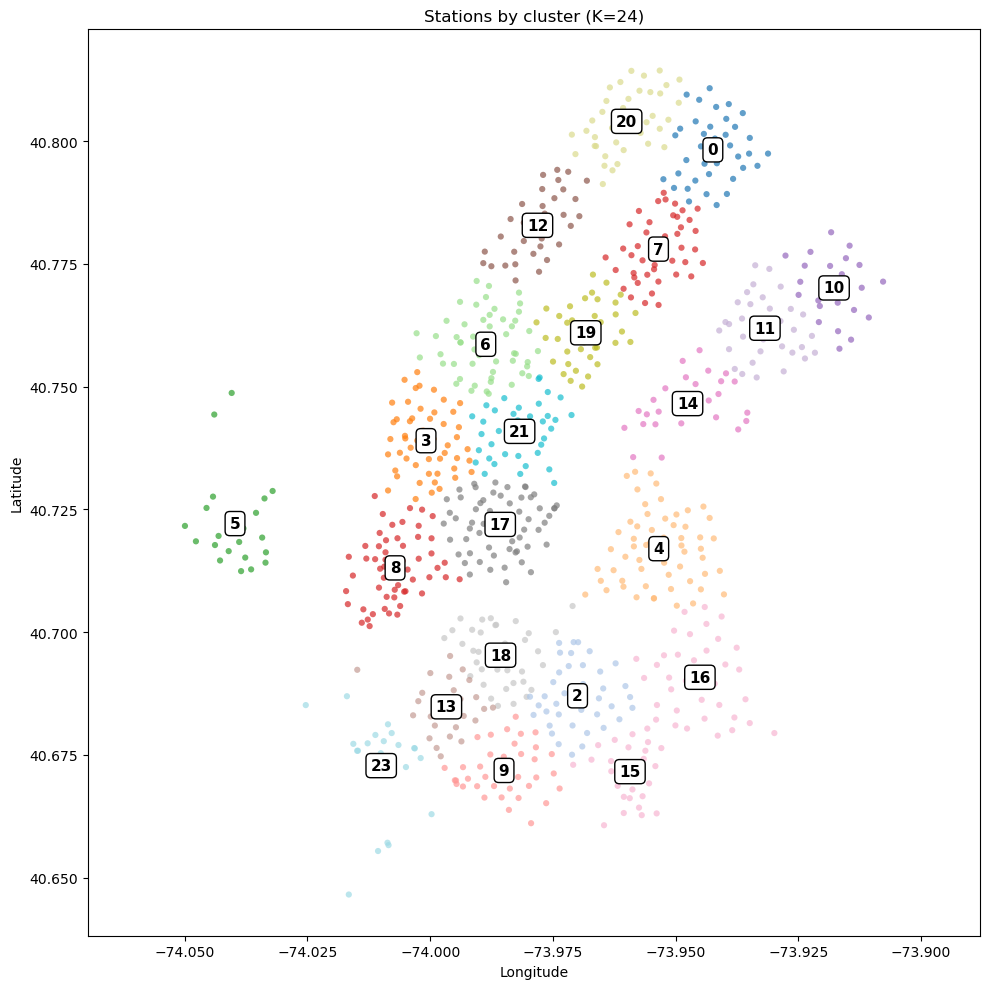

In [27]:
# Plot clusters with labels to sanity-check spatial grouping
stations_plot = station_master.merge(cluster_map, on="station_id", how="left")

nyc = stations_plot[
    (stations_plot["lat"] > 40.60) & (stations_plot["lat"] < 40.90) &
    (stations_plot["lon"] > -74.05) & (stations_plot["lon"] < -73.85)
]

plt.figure(figsize=(10, 10))
plt.scatter(
    nyc["lon"], nyc["lat"],
    c=nyc["cluster_id"],
    cmap="tab20",
    s=20,
    alpha=0.7,
    edgecolor="none",
)

centers = nyc.groupby("cluster_id")[["lat", "lon"]].mean()
for cid, row in centers.iterrows():
    plt.text(
        row["lon"],
        row["lat"],
        str(int(cid)),
        fontsize=11,
        weight="bold",
        color="black",
        ha="center",
        va="center",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=1),
    )

plt.title(f"Stations by cluster (K={K})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.tight_layout()
plt.show()


### 2.5 Elbow curve choice

Plot the elbow curve and briefly justify choosing 24 clusters instead of a smaller or larger number.

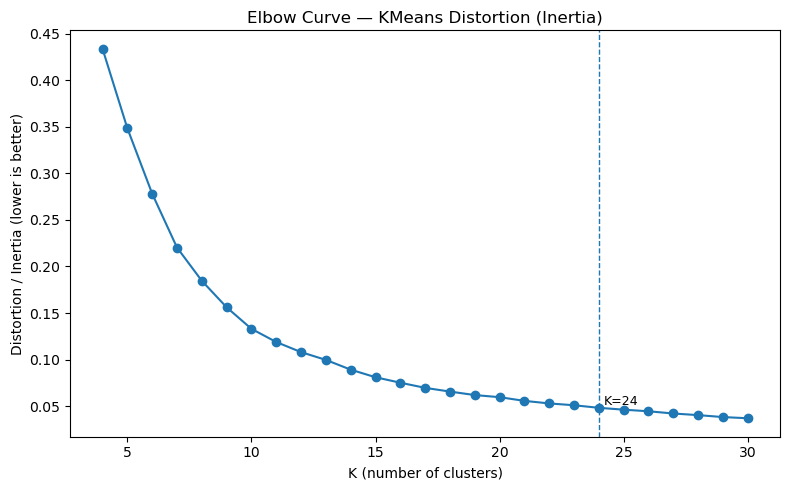

,K,inertia
0,4,0.433705
1,5,0.348407
2,6,0.278208
3,7,0.220379
4,8,0.184651
5,9,0.156198
6,10,0.133067
7,11,0.118914
8,12,0.108069
9,13,0.099711


In [28]:
# Elbow curve to inspect inertia across K values
lat0 = float(station_master["lat"].mean())
X = np.column_stack([
    station_master["lat"].to_numpy(),
    station_master["lon"].to_numpy() * np.cos(np.deg2rad(lat0)),
])

K_VALUES = list(range(4, 31))  
inertias = []
for K in K_VALUES:
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_) 

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(K_VALUES, inertias, marker="o")
ax.set_title("Elbow Curve — KMeans Distortion (Inertia)")
ax.set_xlabel("K (number of clusters)")
ax.set_ylabel("Distortion / Inertia (lower is better)")

k_mark = 24
if k_mark in K_VALUES:
    ax.axvline(k_mark, linestyle="--", linewidth=1)
    ax.text(k_mark + 0.2, np.interp(k_mark, K_VALUES, inertias),
            f"K={k_mark}", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

display(pd.DataFrame({"K": K_VALUES, "inertia": inertias}).head(25))


### 2.6 Hourly series by cluster

Aggregate rides per hour for each cluster and highlight the busiest areas plus typical pickup and dropoff volumes.

Reading: trips_2018.csv
df_hourly built: (214488, 4) | hours: 2018-01-01 00:00:00 → 2019-01-08 08:00:00 | clusters: 24


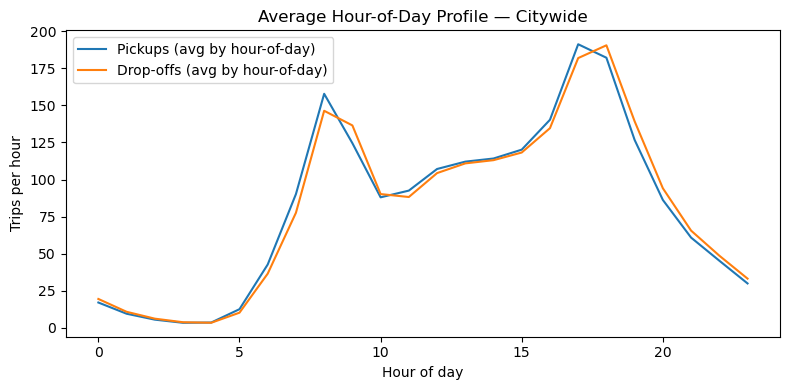

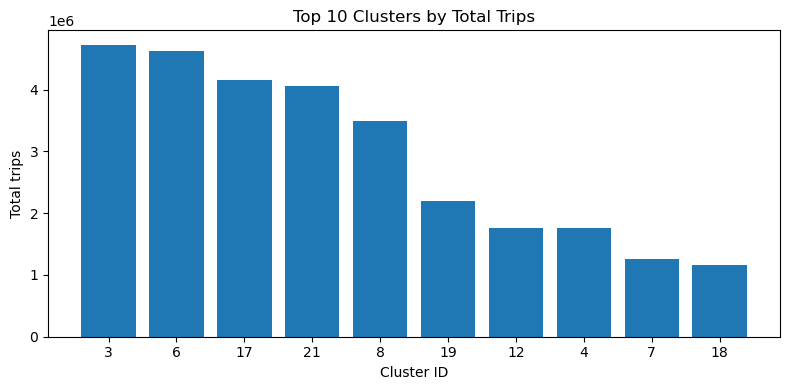

In [ ]:
# Aggregate hourly pickup/dropoff counts by cluster into df_hourly
cluster_lookup = dict(zip(cluster_map["station_id"].astype("Int32"), cluster_map["cluster_id"].astype(int)))

def aggregate_hourly_by_cluster():
    counter_pick = Counter()
    counter_drop = Counter()
    min_ts = None
    max_ts = None

    for chunk in yield_clean_chunks():
        if {"hour_start","start_station_id"}.issubset(chunk.columns):
            sid = chunk["start_station_id"].astype("Int32")
            cid = sid.map(cluster_lookup)
            ts  = chunk["hour_start"]
            m = cid.notna() & ts.notna()
            if m.any():
                dfp = pd.DataFrame({"ts": ts[m].values, "cluster_id": cid[m].astype(int).values})
                vc = dfp.value_counts()
                for (tsi, cidi), cnt in vc.items():
                    counter_pick[(tsi, cidi)] += int(cnt)
                if min_ts is None or dfp["ts"].min() < min_ts: min_ts = dfp["ts"].min()
                if max_ts is None or dfp["ts"].max() > max_ts: max_ts = dfp["ts"].max()

        if {"hour_end","end_station_id"}.issubset(chunk.columns):
            sid = chunk["end_station_id"].astype("Int32")
            cid = sid.map(cluster_lookup)
            ts  = chunk["hour_end"]
            m = cid.notna() & ts.notna()
            if m.any():
                dfd = pd.DataFrame({"ts": ts[m].values, "cluster_id": cid[m].astype(int).values})
                vc = dfd.value_counts()
                for (tsi, cidi), cnt in vc.items():
                    counter_drop[(tsi, cidi)] += int(cnt)
                if min_ts is None or dfd["ts"].min() < min_ts: min_ts = dfd["ts"].min()
                if max_ts is None or dfd["ts"].max() > max_ts: max_ts = dfd["ts"].max()

    all_clusters = np.sort(cluster_map["cluster_id"].unique())
    hours = pd.date_range(min_ts, max_ts, freq="H")
    idx = pd.MultiIndex.from_product([hours, all_clusters], names=["ts","cluster_id"])

    dfh = pd.DataFrame(index=idx).reset_index()
    dfh["pickups"]  = 0
    dfh["dropoffs"] = 0

    if counter_pick:
        tps = pd.DataFrame(
            [(ts, cid, cnt) for (ts, cid), cnt in counter_pick.items()],
            columns=["ts","cluster_id","cnt"]
        )
        dfh = dfh.merge(tps, on=["ts","cluster_id"], how="left").rename(columns={"cnt":"_p"})
        dfh["_p"] = dfh["_p"].fillna(0).astype(int)
        dfh["pickups"] = dfh["_p"]; dfh.drop(columns="_p", inplace=True)

    if counter_drop:
        tds = pd.DataFrame(
            [(ts, cid, cnt) for (ts, cid), cnt in counter_drop.items()],
            columns=["ts","cluster_id","cnt"]
        )
        dfh = dfh.merge(tds, on=["ts","cluster_id"], how="left").rename(columns={"cnt":"_d"})
        dfh["_d"] = dfh["_d"].fillna(0).astype(int)
        dfh["dropoffs"] = dfh["_d"]; dfh.drop(columns="_d", inplace=True)

    dfh[["pickups","dropoffs"]] = dfh[["pickups","dropoffs"]].astype(np.int64)

    print("df_hourly built:", dfh.shape, 
          "| hours:", dfh["ts"].min(), "→", dfh["ts"].max(),
          "| clusters:", dfh["cluster_id"].nunique())
    return dfh


df_hourly = aggregate_hourly_by_cluster()

prof = (df_hourly
        .assign(hod=df_hourly["ts"].dt.hour)
        .groupby("hod")[['pickups',"dropoffs"]]
        .mean()
        .reset_index())

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(prof["hod"], prof["pickups"], label="Pickups (avg by hour-of-day)")
ax.plot(prof["hod"], prof["dropoffs"], label="Drop-offs (avg by hour-of-day)")
ax.set_title("Average Hour-of-Day Profile — Citywide")
ax.set_xlabel("Hour of day"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout()
plt.show()

totals = (df_hourly.assign(total=df_hourly["pickups"]+df_hourly["dropoffs"])
          .groupby("cluster_id")["total"].sum().sort_values(ascending=False))

top10 = totals.head(10)
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(top10.index.astype(str), top10.values)
ax.set_title("Top 10 Clusters by Total Trips")
ax.set_xlabel("Cluster ID"); ax.set_ylabel("Total trips")
plt.tight_layout()
plt.show()


### 2.7 Naive baseline

Create a simple baseline forecast and check how it performs to set a reference point.

Train: 2018-01-01 00:00:00 → 2019-01-08 08:00:00 rows: 179352
Test : 2018-11-01 00:00:00 → 2018-12-31 23:00:00 rows: 35136
Metrics computed (not saved to disk).


/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_26923/2961112765.py:66: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))


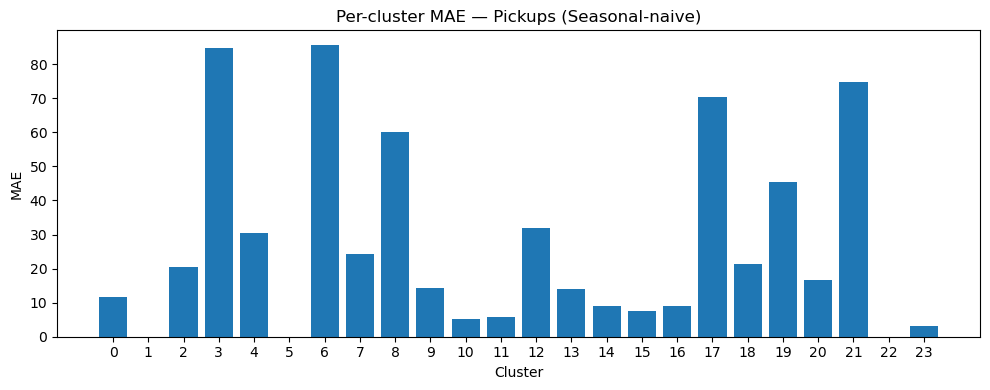

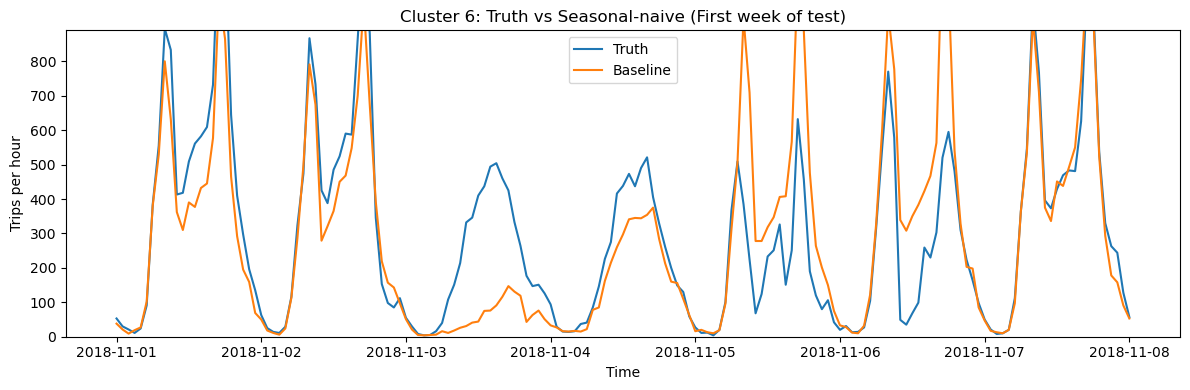

In [30]:
# Split Jan–Oct for training and Nov–Dec for testing
dfx = df_hourly.copy()
dfx["month"] = dfx["ts"].dt.month

train = dfx[dfx["month"].between(1, 10)].drop(columns=["month"])
test  = dfx[dfx["month"].between(11, 12)].drop(columns=["month"])

if test.empty:
    print("Test set is empty (no Nov-Dec hours found). "
          "For demo you can temporarily set test = last 20% of time.")
else:
    print("Train:", train["ts"].min(), "→", train["ts"].max(), "rows:", len(train))
    print("Test :", test["ts"].min(),  "→", test["ts"].max(),  "rows:", len(test))

H_WEEK = 24 * 7

def seasonal_naive(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    df = (pd.concat([train_df[["ts","cluster_id",target]],
                     test_df[["ts","cluster_id",target]]], ignore_index=True)
            .sort_values(["cluster_id","ts"]).reset_index(drop=True))
    df["y_hat"] = np.nan

    for cid, g in df.groupby("cluster_id", sort=False):
        idx = g.index
        vals = g[target].to_numpy()
        yhat = np.full_like(vals, np.nan, dtype="float64")
        if len(vals) > H_WEEK:
            yhat[H_WEEK:] = vals[:-H_WEEK]
        df.loc[idx, "y_hat"] = yhat

    df["hod"] = df["ts"].dt.hour
    hod_mean = (train_df
                .assign(hod=train_df["ts"].dt.hour)
                .groupby(["cluster_id","hod"])[target]
                .mean()
                .rename("hod_mean"))
    df = df.merge(hod_mean, on=["cluster_id","hod"], how="left")
    df["y_hat"] = df["y_hat"].fillna(df["hod_mean"])

    out = df[(df["ts"] >= test_df["ts"].min()) & (df["ts"] <= test_df["ts"].max())]
    return out[["ts","cluster_id","y_hat"]].reset_index(drop=True)

yhat_pickups_bl  = seasonal_naive(train, test, "pickups")
yhat_dropoffs_bl = seasonal_naive(train, test, "dropoffs")

def mase_denominator(train_df: pd.DataFrame, target: str, season=H_WEEK):
    den = {}
    for cid, g in train_df.groupby("cluster_id", sort=False):
        y = g[target].astype(float).to_numpy()
        if len(y) > season:
            den[cid] = np.abs(y[season:] - y[:-season]).mean()
        else:
            den[cid] = np.nan
    return den

def evaluate(test_df: pd.DataFrame, yhat_df: pd.DataFrame, target: str, tag: str):
    df = test_df.merge(yhat_df, on=["ts","cluster_id"], how="left")
    df["y_hat"] = df["y_hat"].clip(lower=0)
    df["e"] = df[target] - df["y_hat"]

    den = mase_denominator(train, target)
    rows = []
    for cid, g in df.groupby("cluster_id", sort=False):
        mae  = float(np.mean(np.abs(g["e"])))
        rmse = float(sqrt(np.mean(np.square(g["e"]))))
        wape = float(np.sum(np.abs(g["e"])) / max(1e-9, np.sum(g[target])))
        mase = float(mae / den.get(cid, np.nan))
        rows.append((tag, cid, mae, rmse, mase, wape))
    return pd.DataFrame(rows, columns=["model","cluster_id","MAE","RMSE","MASE","WAPE"])

metrics_pickups  = evaluate(test, yhat_pickups_bl,  "pickups",  "baseline_seasonal_naive")
metrics_dropoffs = evaluate(test, yhat_dropoffs_bl, "dropoffs", "baseline_seasonal_naive")
metrics = pd.concat([metrics_pickups, metrics_dropoffs], ignore_index=True)
print("Metrics computed (not saved to disk).")

def p95_clip(values: np.ndarray):
    return (0, float(np.nanpercentile(values, 95)))

fig, ax = plt.subplots(figsize=(10, 4))
m = metrics_pickups.sort_values("cluster_id")
ax.bar(m["cluster_id"].astype(str), m["MAE"])
ax.set_title("Per-cluster MAE — Pickups (Seasonal-naive)")
ax.set_xlabel("Cluster")
ax.set_ylabel("MAE")
plt.tight_layout()
plt.show()

totals_test = (test.assign(total=test["pickups"]+test["dropoffs"])
                    .groupby("cluster_id")["total"].sum())
sample_cluster = int(totals_test.sort_values(ascending=False).index[0])

ts_truth_p = test[test["cluster_id"]==sample_cluster].set_index("ts")["pickups"]
ts_hat_p   = yhat_pickups_bl[yhat_pickups_bl["cluster_id"]==sample_cluster].set_index("ts")["y_hat"]

start_ts = ts_truth_p.index.min()
end_ts = start_ts + pd.Timedelta(hours=H_WEEK)

ts_truth_week = ts_truth_p.loc[start_ts:end_ts]
ts_hat_week   = ts_hat_p.loc[start_ts:end_ts]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts_truth_week.index, ts_truth_week.values, label="Truth")
ax.plot(ts_hat_week.index,   ts_hat_week.values,   label="Baseline")
yl = np.r_[ts_truth_week.values, ts_hat_week.values]
lo, hi = p95_clip(yl)
ax.set_ylim(lo, hi)
ax.set_title(f"Cluster {sample_cluster}: Truth vs Seasonal-naive (First week of test)")
ax.set_xlabel("Time")
ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout()
plt.show()

### 2.8 Lag and calendar regression

Build a regression model with time lags and calendar features to predict the next hour of demand.

/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_26923/2961112765.py:66: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))


Updated metrics with upgraded Linear model (not saved).


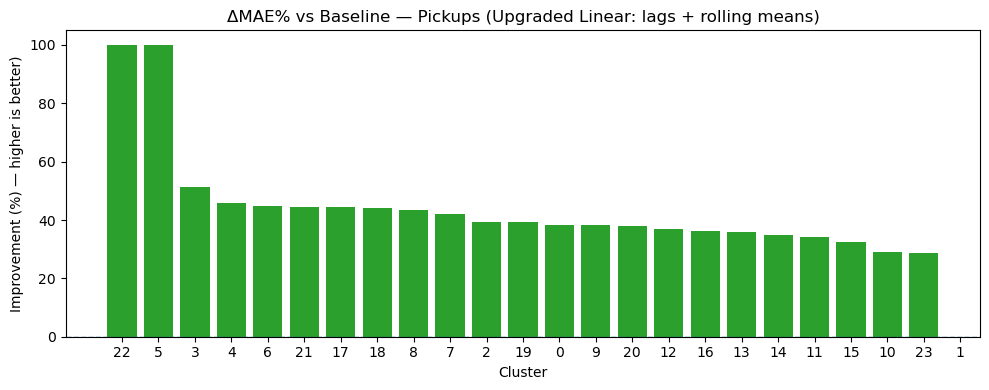

In [31]:
# Baseline ridge with lags/rolling means per cluster
LAGS   = [1, 2, 24, 48, 168]   
RMEANS = [24, 168]           

def build_features_adv(df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Leakage-safe features per cluster:
      y, lag_{1,2,24,48,168}, rm_{24,168} (shifted by 1h), and hour/day dummies.
    """
    g = df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)

    grp = g.groupby("cluster_id", sort=False)
    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)

    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(window=W, min_periods=W).mean())

    g["hod"] = g["ts"].dt.hour.astype("int8")
    g["dow"] = g["ts"].dt.dayofweek.astype("int8")
    g = pd.get_dummies(g, columns=["hod","dow"], drop_first=True)

    keep = ["ts","cluster_id","y"] + [c for c in g.columns if c.startswith(("lag_","rm_","hod_","dow_"))]
    return g[keep]

def fit_predict_linear_adv(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Fit LinearRegression per cluster using richer lag features; predict the test horizon.
    Falls back to seasonal-naive if a cluster lacks enough training rows with complete lags.
    """
    full = pd.concat([train_df, test_df], ignore_index=True)
    F = build_features_adv(full, target)

    mask_te = (F["ts"] >= test_df["ts"].min()) & (F["ts"] <= test_df["ts"].max())
    F_tr, F_te = F.loc[~mask_te].copy(), F.loc[mask_te].copy()

    preds = []
    for cid, gtr in F_tr.groupby("cluster_id", sort=False):
        gte = F_te[F_te["cluster_id"] == cid].copy()
        if gte.empty:
            continue

        X_cols = [c for c in gtr.columns if c not in {"ts","cluster_id","y"}]
        tr_ok = gtr[X_cols].notna().all(axis=1)

        if tr_ok.sum() < 200:  
            tmp = seasonal_naive(train_df[train_df["cluster_id"]==cid],
                                 test_df [test_df ["cluster_id"]==cid], target)
            preds.append(tmp)
            continue

        for c in X_cols:
            if c not in gte.columns:
                gte[c] = 0.0
        gte[X_cols] = gte[X_cols].fillna(0.0)  

        lr = LinearRegression()
        lr.fit(gtr.loc[tr_ok, X_cols].to_numpy(dtype="float64"),
               gtr.loc[tr_ok, "y"].to_numpy(dtype="float64"))

        yhat = lr.predict(gte[X_cols].to_numpy(dtype="float64"))
        preds.append(pd.DataFrame({"ts": gte["ts"].values,
                                   "cluster_id": cid,
                                   "y_hat": np.clip(yhat, 0, None)}))

    return pd.concat(preds, ignore_index=True)

yhat_pickups_lin  = fit_predict_linear_adv(train, test, "pickups")
yhat_dropoffs_lin = fit_predict_linear_adv(train, test, "dropoffs")
metrics_pickups_lin  = evaluate(test, yhat_pickups_lin,  "pickups",  "linear_lagcal_plus")
metrics_dropoffs_lin = evaluate(test, yhat_dropoffs_lin, "dropoffs", "linear_lagcal_plus")
metrics_upg = pd.concat([metrics, metrics_pickups_lin, metrics_dropoffs_lin], ignore_index=True)
print("Updated metrics with upgraded Linear model (not saved).")

m_base = metrics[metrics["model"].str.contains("baseline", case=False) & metrics["cluster_id"].notna()]
mb = m_base.set_index("cluster_id")["MAE"]
ml = metrics_pickups_lin.set_index("cluster_id")["MAE"]
common = mb.index.intersection(ml.index)
delta_pct = ((mb.loc[common] - ml.loc[common]) / mb.loc[common] * 100.0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
colors = ["#2ca02c" if v>0 else "#d62728" for v in delta_pct.values]
ax.bar(delta_pct.index.astype(str), delta_pct.values, color=colors)
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("ΔMAE% vs Baseline — Pickups (Upgraded Linear: lags + rolling means)")
ax.set_xlabel("Cluster"); ax.set_ylabel("Improvement (%) — higher is better)")
plt.tight_layout()
plt.show()


### 2.9 Weekend-aware ridge

Account for weekend patterns, then fit a ridge model on the residuals to improve one-hour-ahead forecasts.

/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_26923/2961112765.py:66: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))
/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_26923/2961112765.py:66: RuntimeWarning: invalid value encountered in scalar divide
  mase = float(mae / den.get(cid, np.nan))


One-step metrics computed (not saved).


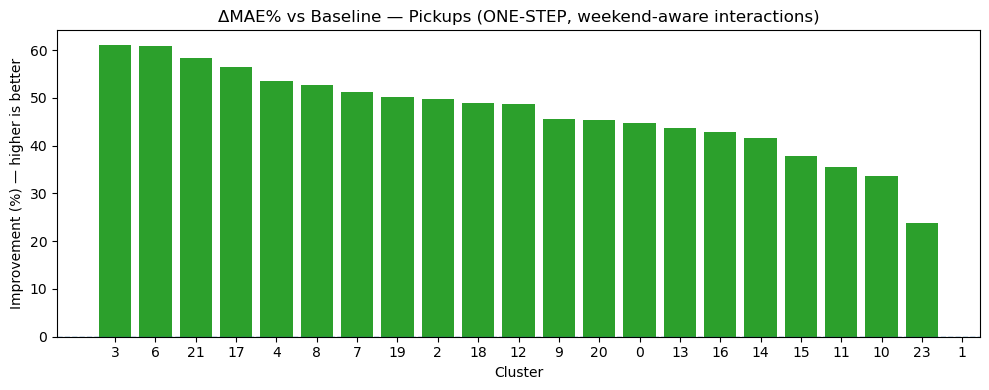

In [ ]:
# Weekend-aware ridge variant with richer lags
LAGS   = [1, 2, 3, 4, 6, 12, 24, 48, 72, 96, 168]
RMEANS = [24, 168]  

def _hour_of_week(ts: pd.Series) -> pd.Series:
    return (ts.dt.dayofweek.astype(int) * 24 + ts.dt.hour.astype(int)).astype("int16")

def build_features_onestep(df: pd.DataFrame, target: str) -> pd.DataFrame:
    g = df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)

    grp = g.groupby("cluster_id", sort=False)
    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)
    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(W, min_periods=W).mean())

    g["y_base"] = g["lag_168"]
    g["y_res"]  = g["y"] - g["y_base"]

    g["is_weekend"] = g["ts"].dt.dayofweek.isin([5, 6]).astype("int8")
    g["is_friday"]  = (g["ts"].dt.dayofweek == 4).astype("int8")
    g["is_sunday"]  = (g["ts"].dt.dayofweek == 6).astype("int8")

    g["how"] = _hour_of_week(g["ts"])
    g = pd.get_dummies(g, columns=["how"], prefix="how", drop_first=True)

    for base in ["lag_24","lag_168","rm_24","rm_168"]:
        g[f"{base}_wk"] = g[base] * g["is_weekend"]

    keep = ["ts","cluster_id","y","y_base","y_res"] + [c for c in g.columns if c.startswith(("lag_","rm_","how_","is_"))]
    g = g[keep]
    assert not any(c in g.columns for c in ("pickups","dropoffs")), "Leakage risk: raw target present!"
    return g

def one_step_linear_how_resid(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    Train Ridge per cluster on TRAIN (target = y_res) and predict ONE-STEP on TEST:
      ŷ_t = y_{t−168} + r̂_t
    With weekend interactions + light weekend up-weighting.
    """
    full = pd.concat([train_df, test_df], ignore_index=True)
    F    = build_features_onestep(full, target)

    mask_te = (F["ts"] >= test_df["ts"].min()) & (F["ts"] <= test_df["ts"].max())
    F_tr, F_te = F.loc[~mask_te].copy(), F.loc[mask_te].copy()

    preds = []
    core_req = ["lag_24","lag_168","rm_24","rm_168"] 

    for cid, gtr in F_tr.groupby("cluster_id", sort=False):
        gte = F_te[F_te["cluster_id"]==cid].copy()
        if gte.empty:
            continue

        X_cols = [c for c in gtr.columns if c not in {"ts","cluster_id","y","y_res","y_base"}]
        tr_ok = gtr[core_req].notna().all(axis=1)
        if tr_ok.sum() < 200:
            tmp = seasonal_naive(train_df[train_df["cluster_id"]==cid],
                                 test_df [test_df ["cluster_id"]==cid], target)
            preds.append(tmp); continue

        non_core = [c for c in X_cols if c not in core_req]
        gtr.loc[:, non_core] = gtr.loc[:, non_core].fillna(0.0)
        gte.loc[:, non_core] = gte.loc[:, non_core].fillna(0.0)
        for c in X_cols:
            if c not in gte.columns:
                gte[c] = 0.0

        w = np.where(gtr["is_weekend"]==1, 1.8, 1.0).astype("float64")

        alpha = 1.2 if tr_ok.sum() >= 1000 else 2.0
        mdl = Ridge(alpha=alpha)
        mdl.fit(gtr.loc[tr_ok, X_cols].to_numpy(dtype="float64"),
                gtr.loc[tr_ok, "y_res"].to_numpy(dtype="float64"),
                sample_weight=w[tr_ok])

        te_ok = gte[core_req + ["y_base"]].notna().all(axis=1)
        yhat  = np.full(len(gte), np.nan, dtype="float64")
        if te_ok.any():
            rhat = mdl.predict(gte.loc[te_ok, X_cols].to_numpy(dtype="float64"))
            yhat[te_ok.values] = gte.loc[te_ok, "y_base"].to_numpy(dtype="float64") + rhat
        if (~te_ok).any():
            yhat[~te_ok.values] = gte.loc[~te_ok, "y_base"].to_numpy(dtype="float64")

        preds.append(pd.DataFrame({"ts": gte["ts"].values, "cluster_id": cid,
                                   "y_hat": np.clip(yhat, 0, None)}))

    return pd.concat(preds, ignore_index=True)

yhat_pickups_1s_lin  = one_step_linear_how_resid(train, test, "pickups")
yhat_dropoffs_1s_lin = one_step_linear_how_resid(train, test, "dropoffs")

yhat_pickups_1s_bl  = seasonal_naive(train, test, "pickups")
yhat_dropoffs_1s_bl = seasonal_naive(train, test, "dropoffs")
metrics_pickups_bl   = evaluate(test, yhat_pickups_1s_bl,  "pickups",  tag="baseline_seasonal_naive_1step")
metrics_dropoffs_bl  = evaluate(test, yhat_dropoffs_1s_bl, "dropoffs", tag="baseline_seasonal_naive_1step")
metrics_pickups_lin  = evaluate(test, yhat_pickups_1s_lin, "pickups",  tag="linear_how_resid_weekend_1step")
metrics_dropoffs_lin = evaluate(test, yhat_dropoffs_1s_lin,"dropoffs", tag="linear_how_resid_weekend_1step")

metrics_1step = pd.concat([metrics_pickups_bl, metrics_dropoffs_bl,
                           metrics_pickups_lin, metrics_dropoffs_lin], ignore_index=True)
print("One-step metrics computed (not saved).")

mb = metrics_pickups_bl.set_index("cluster_id")["MAE"]
ml = metrics_pickups_lin.set_index("cluster_id")["MAE"]
common = mb.index.intersection(ml.index)
delta_pct = ((mb.loc[common] - ml.loc[common]) / mb.loc[common] * 100.0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(delta_pct.index.astype(str), delta_pct.values,
       color=["#2ca02c" if v>0 else "#d62728" for v in delta_pct.values])
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("ΔMAE% vs Baseline — Pickups (ONE-STEP, weekend-aware interactions)")
ax.set_xlabel("Cluster"); ax.set_ylabel("Improvement (%) — higher is better")
plt.tight_layout()
plt.show()


### 2.10 24-hour rolling ridge

Train ridge models for a rolling 24-hour horizon so we can forecast a full day ahead.

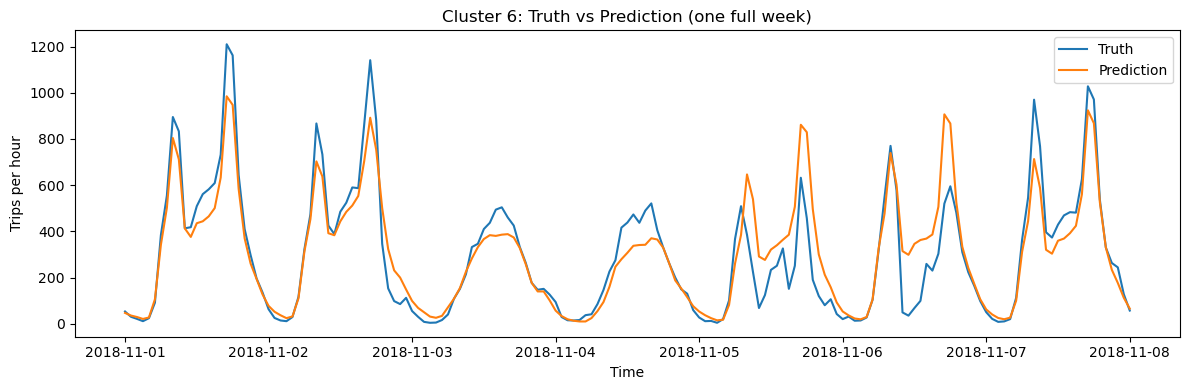

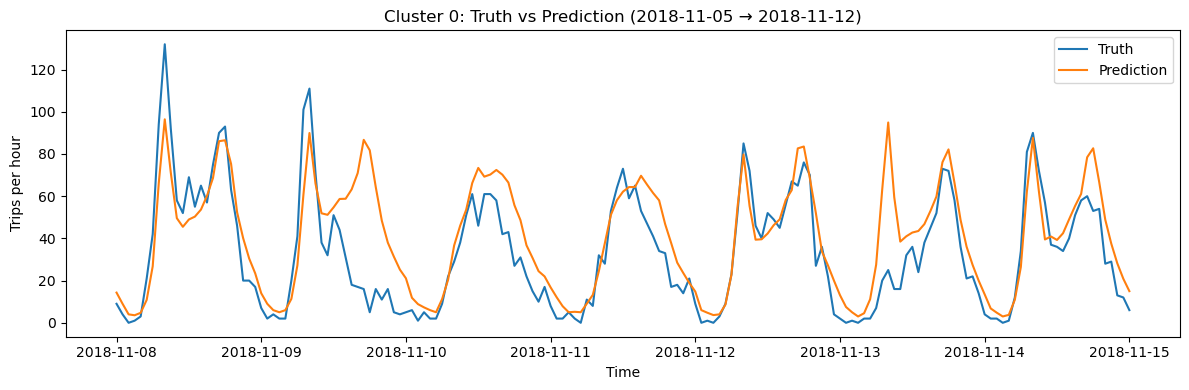

In [33]:
# Rolling 24h ridge forecast per cluster (sequential over days)
LAGS   = [1,2,3,4,6,12,24,48,72,96,168]
RMEANS = [24,168]

def _hour_of_week(ts: pd.Series) -> pd.Series:
    return (ts.dt.dayofweek.astype(int) * 24 + ts.dt.hour.astype(int)).astype("int16")  

def _build_train_matrix(train_df: pd.DataFrame, target: str):
    g = train_df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)
    grp = g.groupby("cluster_id", sort=False)

    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)
    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(W, min_periods=W).mean())

    g["y_base"] = g["lag_168"]
    g["y_res"]  = g["y"] - g["y_base"]

    g["how"] = _hour_of_week(g["ts"])
    g["is_weekend"] = g["ts"].dt.dayofweek.isin([5,6]).astype("int8")
    g["is_friday"]  = (g["ts"].dt.dayofweek == 4).astype("int8")
    g["is_sunday"]  = (g["ts"].dt.dayofweek == 6).astype("int8")

    g = pd.get_dummies(g, columns=["how"], prefix="how", drop_first=True)

    for base in ["lag_24","lag_168","rm_24","rm_168"]:
        g[f"{base}_wk"] = g[base] * g["is_weekend"]

    X_cols = [c for c in g.columns if c.startswith(("lag_","rm_","how_","is_"))]

    models, how_means, how_p95 = {}, {}, {}
    for cid, sub in g.groupby("cluster_id", sort=False):
        how_idx = (sub["ts"].dt.dayofweek*24 + sub["ts"].dt.hour).astype(int)
        hm  = sub.groupby(how_idx)["y"].mean().to_dict()
        hp  = sub.groupby(how_idx)["y"].quantile(0.95).to_dict()
        cid_int = int(cid)
        how_means[cid_int] = {int(k): float(v) for k,v in hm.items()}
        how_p95[cid_int]   = {int(k): float(v) for k,v in hp.items()}

        core_req = ["lag_24","lag_168","rm_24","rm_168"]
        ok = sub[core_req].notna().all(axis=1)
        if ok.sum() < 300:
            models[cid_int] = None
            continue

        non_core = [c for c in X_cols if c not in core_req]
        sub.loc[:, non_core] = sub.loc[:, non_core].fillna(0.0)

        w = np.where(sub["is_weekend"]==1, 1.8, 1.0).astype("float64")

        alpha = 1.2 if ok.sum() >= 1200 else 2.0
        mdl = Ridge(alpha=alpha)
        mdl.fit(sub.loc[ok, X_cols].to_numpy(dtype="float64"),
                sub.loc[ok, "y_res"].to_numpy(dtype="float64"),
                sample_weight=w[ok])
        models[cid_int] = mdl

    return models, X_cols, how_means, how_p95

def _init_rolling_buffers(hist: pd.Series, t0: pd.Timestamp):
    dq24, dq168 = deque(maxlen=24), deque(maxlen=168)
    s24 = s168 = 0.0
    for k in range(24, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq24.append(float(v)); s24 += float(v)
    for k in range(168, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq168.append(float(v)); s168 += float(v)
    return dq24, s24, dq168, s168

def _rm_from_buffer(dq, s, W):
    return (s / W) if len(dq) == W else np.nan

def rolling_forecast_24(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    models, X_cols, how_means, how_p95 = _build_train_matrix(train_df, target)
    preds = []

    full = pd.concat([train_df[["ts","cluster_id",target]],
                      test_df [["ts","cluster_id",target]]], ignore_index=True)
    clusters = np.sort(test_df["cluster_id"].unique())
    days = pd.to_datetime(test_df["ts"].dt.floor("D").unique())

    how_cols = [c for c in X_cols if c.startswith("how_")]
    core_req = ["lag_24","lag_168","rm_24","rm_168"]

    for cid in clusters:
        cid = int(cid)
        mdl = models.get(cid)
        series = full[full["cluster_id"]==cid].sort_values("ts").set_index("ts")[target].astype(float)
        hist = series.copy()

        t0 = days.min()
        dq24, s24, dq168, s168 = _init_rolling_buffers(hist, t0)

        for d in days:
            for h in range(24):
                t = d + pd.Timedelta(hours=h)

                feats = {}
                how = int(t.dayofweek*24 + t.hour)
                feats[f"how_{how}"] = 1.0
                feats["is_weekend"] = int(t.weekday() >= 5)
                feats["is_friday"]  = int(t.weekday() == 4)
                feats["is_sunday"]  = int(t.weekday() == 6)
                for L in LAGS:
                    feats[f"lag_{L}"] = hist.get(t - pd.Timedelta(hours=L), np.nan)
                feats["rm_24"]  = _rm_from_buffer(dq24,  s24,  24)
                feats["rm_168"] = _rm_from_buffer(dq168, s168, 168)
                feats["lag_24_wk"]  = feats["lag_24"]  * feats["is_weekend"] if not np.isnan(feats["lag_24"])  else np.nan
                feats["lag_168_wk"] = feats["lag_168"] * feats["is_weekend"] if not np.isnan(feats["lag_168"]) else np.nan
                feats["rm_24_wk"]   = feats["rm_24"]   * feats["is_weekend"] if not np.isnan(feats["rm_24"])   else np.nan
                feats["rm_168_wk"]  = feats["rm_168"]  * feats["is_weekend"] if not np.isnan(feats["rm_168"])  else np.nan

                y_base = hist.get(t - pd.Timedelta(hours=168), np.nan)
                if np.isnan(y_base):
                    y_base = how_means.get(cid, {}).get(how, 0.0)

                x = []
                core_missing = False
                for c in X_cols:
                    val = feats.get(c, 0.0 if c.startswith(("how_","is_")) else np.nan)
                    if c in core_req and (not isinstance(val, (int,float)) or np.isnan(val)):
                        core_missing = True
                    x.append(val if not (isinstance(val,float) and np.isnan(val)) else 0.0)
                x = np.asarray(x, dtype="float64")

                if mdl is None or core_missing:
                    yhat = y_base
                else:
                    rhat = float(mdl.predict(x.reshape(1, -1))[0])
                    yhat = y_base + rhat

                cap = how_p95.get(cid, {}).get(how, np.inf)
                yhat = max(0.0, min(yhat, cap))

                preds.append((t, cid, yhat))
                hist.loc[t] = yhat

                if len(dq24) == 24:   s24  -= dq24[0]
                if len(dq168) == 168: s168 -= dq168[0]
                dq24.append(yhat);   s24  += yhat
                dq168.append(yhat); s168 += yhat

    out = (pd.DataFrame(preds, columns=["ts","cluster_id","y_hat"])
             .sort_values(["ts","cluster_id"]).reset_index(drop=True))
    return out

yhat_pickups_24  = rolling_forecast_24(train, test, "pickups")
yhat_dropoffs_24 = rolling_forecast_24(train, test, "dropoffs")

totals_test = (test.assign(total=test["pickups"]+test["dropoffs"])
                    .groupby("cluster_id")["total"].sum())
cid = int(totals_test.sort_values(ascending=False).index[0])

start_week = test["ts"].min().ceil("D")
end_week   = start_week + pd.Timedelta(days=7)

truth = test[(test["cluster_id"]==cid) & (test["ts"].between(start_week, end_week))]        .set_index("ts")["pickups"]
pred  = yhat_pickups_24[(yhat_pickups_24["cluster_id"]==cid) & (yhat_pickups_24["ts"].between(start_week, end_week))]        .set_index("ts")["y_hat"]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(truth.index, truth.values, label="Truth")
ax.plot(pred.index,  pred.values,  label="Prediction")
ax.set_title(f"Cluster {cid}: Truth vs Prediction (one full week)")
ax.set_xlabel("Time"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout()
plt.show()

cid_custom = 0
start_custom = pd.Timestamp("2018-11-08")
end_custom   = pd.Timestamp("2018-11-15")

truth0 = (test
          .loc[(test["cluster_id"]==cid_custom) & (test["ts"].between(start_custom, end_custom))]
          .set_index("ts")["pickups"])
pred0  = (yhat_pickups_24
          .loc[(yhat_pickups_24["cluster_id"]==cid_custom) & (yhat_pickups_24["ts"].between(start_custom, end_custom))]
          .set_index("ts")["y_hat"])

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(truth0.index, truth0.values, label="Truth")
ax.plot(pred0.index,  pred0.values,  label="Prediction")
ax.set_title("Cluster 0: Truth vs Prediction (2018-11-05 → 2018-11-12)")
ax.set_xlabel("Time"); ax.set_ylabel("Trips per hour")
ax.legend()
plt.tight_layout()
plt.show()


### 2.11 Citywide demand prediction

Apply the chosen model across the whole city to generate pickup and dropoff demand forecasts.

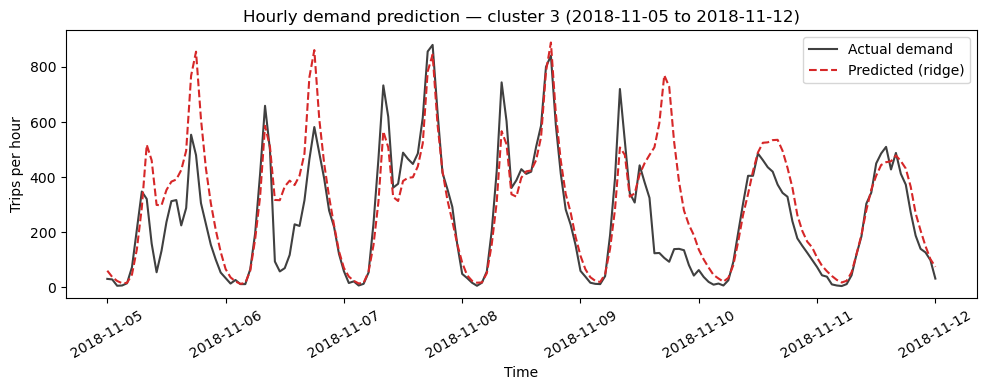

In [34]:
# Generate citywide forecasts and sample plots for city + top cluster
LAGS   = [1,2,3,4,6,12,24,48,72,96,168]
RMEANS = [24,168]

def _hour_of_week(ts: pd.Series) -> pd.Series:
    return (ts.dt.dayofweek.astype(int) * 24 + ts.dt.hour.astype(int)).astype("int16")  

def _build_train_matrix(train_df: pd.DataFrame, target: str):
    g = train_df.sort_values(["cluster_id","ts"]).copy()
    g["y"] = g[target].astype(float)
    grp = g.groupby("cluster_id", sort=False)

    for L in LAGS:
        g[f"lag_{L}"] = grp["y"].shift(L)
    for W in RMEANS:
        g[f"rm_{W}"] = grp["y"].transform(lambda s: s.shift(1).rolling(W, min_periods=W).mean())

    g["y_base"] = g["lag_168"]
    g["y_res"]  = g["y"] - g["y_base"]

    g["how"] = _hour_of_week(g["ts"])
    g["is_weekend"] = g["ts"].dt.dayofweek.isin([5,6]).astype("int8")
    g["is_friday"]  = (g["ts"].dt.dayofweek == 4).astype("int8")
    g["is_sunday"]  = (g["ts"].dt.dayofweek == 6).astype("int8")

    g = pd.get_dummies(g, columns=["how"], prefix="how", drop_first=True)

    for base in ["lag_24","lag_168","rm_24","rm_168"]:
        g[f"{base}_wk"] = g[base] * g["is_weekend"]

    X_cols = [c for c in g.columns if c.startswith(("lag_","rm_","how_","is_"))]

    models, how_means, how_p95 = {}, {}, {}
    for cid, sub in g.groupby("cluster_id", sort=False):
        how_idx = (sub["ts"].dt.dayofweek*24 + sub["ts"].dt.hour).astype(int)
        hm  = sub.groupby(how_idx)["y"].mean().to_dict()
        hp  = sub.groupby(how_idx)["y"].quantile(0.95).to_dict()
        cid_int = int(cid)
        how_means[cid_int] = {int(k): float(v) for k,v in hm.items()}
        how_p95[cid_int]   = {int(k): float(v) for k,v in hp.items()}

        core_req = ["lag_24","lag_168","rm_24","rm_168"]
        ok = sub[core_req].notna().all(axis=1)
        if ok.sum() < 300:
            models[cid_int] = None
            continue

        non_core = [c for c in X_cols if c not in core_req]
        sub.loc[:, non_core] = sub.loc[:, non_core].fillna(0.0)

        w = np.where(sub["is_weekend"]==1, 1.8, 1.0).astype("float64")

        alpha = 1.2 if ok.sum() >= 1200 else 2.0
        mdl = Ridge(alpha=alpha)
        mdl.fit(sub.loc[ok, X_cols].to_numpy(dtype="float64"),
                sub.loc[ok, "y_res"].to_numpy(dtype="float64"),
                sample_weight=w[ok])
        models[cid_int] = mdl

    return models, X_cols, how_means, how_p95

def _init_rolling_buffers(hist: pd.Series, t0: pd.Timestamp):
    dq24, dq168 = deque(maxlen=24), deque(maxlen=168)
    s24 = s168 = 0.0
    for k in range(24, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq24.append(float(v)); s24 += float(v)
    for k in range(168, 0, -1):
        v = hist.get(t0 - pd.Timedelta(hours=k), np.nan)
        if not np.isnan(v): dq168.append(float(v)); s168 += float(v)
    return dq24, s24, dq168, s168

def _rm_from_buffer(dq, s, W):
    return (s / W) if len(dq) == W else np.nan

def rolling_forecast_24(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str) -> pd.DataFrame:
    models, X_cols, how_means, how_p95 = _build_train_matrix(train_df, target)
    preds = []

    full = pd.concat([train_df[["ts","cluster_id",target]],
                      test_df [["ts","cluster_id",target]]], ignore_index=True)
    clusters = np.sort(test_df["cluster_id"].unique())
    days = pd.to_datetime(test_df["ts"].dt.floor("D").unique())

    core_req = ["lag_24","lag_168","rm_24","rm_168"]

    for cid in clusters:
        cid = int(cid)
        mdl = models.get(cid)
        series = full[full["cluster_id"]==cid].sort_values("ts").set_index("ts")[target].astype(float)
        hist = series.copy()

        t0 = days.min()
        dq24, s24, dq168, s168 = _init_rolling_buffers(hist, t0)

        for d in days:
            for h in range(24):
                t = d + pd.Timedelta(hours=h)

                feats = {}
                how = int(t.dayofweek*24 + t.hour)
                feats[f"how_{how}"] = 1.0
                feats["is_weekend"] = int(t.weekday() >= 5)
                feats["is_friday"]  = int(t.weekday() == 4)
                feats["is_sunday"]  = int(t.weekday() == 6)
                for L in LAGS:
                    feats[f"lag_{L}"] = hist.get(t - pd.Timedelta(hours=L), np.nan)
                feats["rm_24"]  = _rm_from_buffer(dq24,  s24,  24)
                feats["rm_168"] = _rm_from_buffer(dq168, s168, 168)
                feats["lag_24_wk"]  = feats["lag_24"]  * feats["is_weekend"] if not np.isnan(feats["lag_24"])  else np.nan
                feats["lag_168_wk"] = feats["lag_168"] * feats["is_weekend"] if not np.isnan(feats["lag_168"]) else np.nan
                feats["rm_24_wk"]   = feats["rm_24"]   * feats["is_weekend"] if not np.isnan(feats["rm_24"])   else np.nan
                feats["rm_168_wk"]  = feats["rm_168"]  * feats["is_weekend"] if not np.isnan(feats["rm_168"])  else np.nan

                y_base = hist.get(t - pd.Timedelta(hours=168), np.nan)
                if np.isnan(y_base):
                    y_base = how_means.get(cid, {}).get(how, 0.0)

                x = []
                core_missing = False
                for c in X_cols:
                    val = feats.get(c, 0.0 if c.startswith(("how_","is_")) else np.nan)
                    if c in core_req and (not isinstance(val, (int,float)) or np.isnan(val)):
                        core_missing = True
                    x.append(val if not (isinstance(val,float) and np.isnan(val)) else 0.0)
                x = np.asarray(x, dtype="float64")

                if mdl is None or core_missing:
                    yhat = y_base
                else:
                    rhat = float(mdl.predict(x.reshape(1, -1))[0])
                    yhat = y_base + rhat

                cap = how_p95.get(cid, {}).get(how, np.inf)
                yhat = max(0.0, min(yhat, cap))

                preds.append((t, cid, yhat))
                hist.loc[t] = yhat

                if len(dq24) == 24:   s24  -= dq24[0]
                if len(dq168) == 168: s168 -= dq168[0]
                dq24.append(yhat);   s24  += yhat
                dq168.append(yhat); s168 += yhat

    out = (pd.DataFrame(preds, columns=["ts","cluster_id","y_hat"])
             .sort_values(["ts","cluster_id"]).reset_index(drop=True))
    return out

yhat_pickups_24  = rolling_forecast_24(train, test, "pickups")
yhat_dropoffs_24 = rolling_forecast_24(train, test, "dropoffs")

week1_start = pd.Timestamp("2018-11-01")
week1_end   = week1_start + pd.Timedelta(days=7)
week2_start = week1_end
week2_end   = week2_start + pd.Timedelta(days=7)

truth_city_w1 = (test
                 .loc[test["ts"].between(week1_start, week1_end)]
                 .groupby("ts")[["pickups","dropoffs"]]
                 .sum()
                 .sort_index())

truth_city_w2 = (test
                 .loc[test["ts"].between(week2_start, week2_end)]
                 .groupby("ts")[["pickups","dropoffs"]]
                 .sum()
                 .sort_index())

pred_pickups_w1 = (yhat_pickups_24
                   .loc[yhat_pickups_24["ts"].between(week1_start, week1_end)]
                   .groupby("ts")["y_hat"]
                   .sum()
                   .reindex(truth_city_w1.index))

pred_dropoffs_w1 = (yhat_dropoffs_24
                    .loc[yhat_dropoffs_24["ts"].between(week1_start, week1_end)]
                    .groupby("ts")["y_hat"]
                    .sum()
                    .reindex(truth_city_w1.index))

pred_pickups_w2 = (yhat_pickups_24
                   .loc[yhat_pickups_24["ts"].between(week2_start, week2_end)]
                   .groupby("ts")["y_hat"]
                   .sum()
                   .reindex(truth_city_w2.index))

pred_dropoffs_w2 = (yhat_dropoffs_24
                    .loc[yhat_dropoffs_24["ts"].between(week2_start, week2_end)]
                    .groupby("ts")["y_hat"]
                    .sum()
                    .reindex(truth_city_w2.index))



top_cluster = int(df_hourly.groupby("cluster_id")["pickups"].sum().idxmax())

def _cluster_week(pred_df: pd.DataFrame, truth_df: pd.DataFrame, cid: int, start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
    truth = (truth_df
             .loc[(truth_df["cluster_id"] == cid) & (truth_df["ts"].between(start, end))]
             .set_index("ts")["pickups"])
    pred = (pred_df
            .loc[(pred_df["cluster_id"] == cid) & (pred_df["ts"].between(start, end))]
            .set_index("ts")["y_hat"])
    return pd.DataFrame({
        "truth": truth,
        "pred": pred.reindex(truth.index),
    })

zoom_start = pd.Timestamp("2018-11-05")
zoom_end = pd.Timestamp("2018-11-12")

cluster_week = _cluster_week(yhat_pickups_24, test, top_cluster, zoom_start, zoom_end)

plt.figure(figsize=(10, 4))
plt.plot(cluster_week.index, cluster_week["truth"], color="black", linewidth=1.3, label="Actual demand")
plt.plot(cluster_week.index, cluster_week["pred"], color="tab:red", linestyle="--", linewidth=1.2, label="Predicted (ridge)")
plt.title(f"Hourly demand prediction — cluster {top_cluster} ({zoom_start.date()} to {zoom_end.date()})")
plt.ylabel("Trips per hour")
plt.xlabel("Time")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


### 2.12 Citywide metrics

Summarize error metrics for the city-level forecasts to see how well the model generalizes.

In [35]:
# Helper: compute MAE/RMSE/WAPE/MAPE for predictions
def compute_citywide_metrics(test_df: pd.DataFrame, pred_df: pd.DataFrame, target: str):
    df = test_df[["ts","cluster_id",target]].merge(
        pred_df[["ts","cluster_id","y_hat"]],
        on=["ts","cluster_id"],
        how="inner",
    )

    y = df[target].astype(float).to_numpy()
    yhat = df["y_hat"].astype(float).clip(lower=0).to_numpy()  
    e = y - yhat

    mae = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    wape = float(np.sum(np.abs(e)) / max(1e-9, np.sum(y)))

    return {"MAE": mae, "RMSE": rmse, "WAPE": wape}

city_pickups  = compute_citywide_metrics(test, yhat_pickups_24,  "pickups")
city_dropoffs = compute_citywide_metrics(test, yhat_dropoffs_24, "dropoffs")

print("Citywide metrics over full test horizon (row-level across clusters):")
print(f"  Pickups : {city_pickups}")
print(f"  Dropoffs: {city_dropoffs}")


Citywide metrics over full test horizon (row-level across clusters):
  Pickups : {'MAE': 29.992605508715904, 'RMSE': 69.6172011749449, 'WAPE': 0.46287361225315254}
  Dropoffs: {'MAE': 29.84478679020965, 'RMSE': 69.1192790692487, 'WAPE': 0.46054985643240803}


In [36]:
# RF-style metrics to match the exploratory part (MAE/RMSE/WAPE/MAPE).

def rf_style_metrics(test_df, pred_df, target, cluster_ids=None, aggregate_citywide=False):
    df = test_df[["ts", "cluster_id", target]].merge(
        pred_df[["ts", "cluster_id", "y_hat"]],
        on=["ts", "cluster_id"],
        how="inner",
    )
    if cluster_ids is not None:
        df = df[df["cluster_id"].isin(cluster_ids)]
    df["y_hat"] = df["y_hat"].clip(lower=0)
    if aggregate_citywide:
        df = df.groupby("ts", as_index=False).agg({target: "sum", "y_hat": "sum"})

    y = df[target].to_numpy(dtype="float64")
    yhat = df["y_hat"].to_numpy(dtype="float64")
    e = y - yhat

    mae = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e ** 2)))
    wape = float(np.sum(np.abs(e)) / max(1e-9, np.sum(y)))
    mape = float(np.mean(np.abs(e) / np.where(y == 0, 1e-9, y))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

print("Test metrics (Nov–Dec 2018) — pickups, aggregated like exploratory RF:")
print("  Citywide (sum over clusters):", rf_style_metrics(test, yhat_pickups_24, "pickups", aggregate_citywide=True))
print("  Cluster 0:", rf_style_metrics(test, yhat_pickups_24, "pickups", cluster_ids=[0]))
print("  Cluster 6:", rf_style_metrics(test, yhat_pickups_24, "pickups", cluster_ids=[6]))


Test metrics (Nov–Dec 2018) — pickups, aggregated like exploratory RF:
  Citywide (sum over clusters): {'MAE': 680.3837451854841, 'RMSE': 1104.1670765652475, 'WAPE': 0.43751295320776895, 'MAPE_pct': 120.5042843360211}
  Cluster 0: {'MAE': 12.074804549379845, 'RMSE': 17.64387530189174, 'WAPE': 0.43094865578479014, 'MAPE_pct': 18271144173.483047}
  Cluster 6: {'MAE': 86.91031550659558, 'RMSE': 148.69342450574737, 'WAPE': 0.41117046987124234, 'MAPE_pct': 978077291.7171068}


### 2.13 Cluster rebalancing

Use the highest-demand cluster and a representative November day to visualize how predicted flows translate into staging needs.


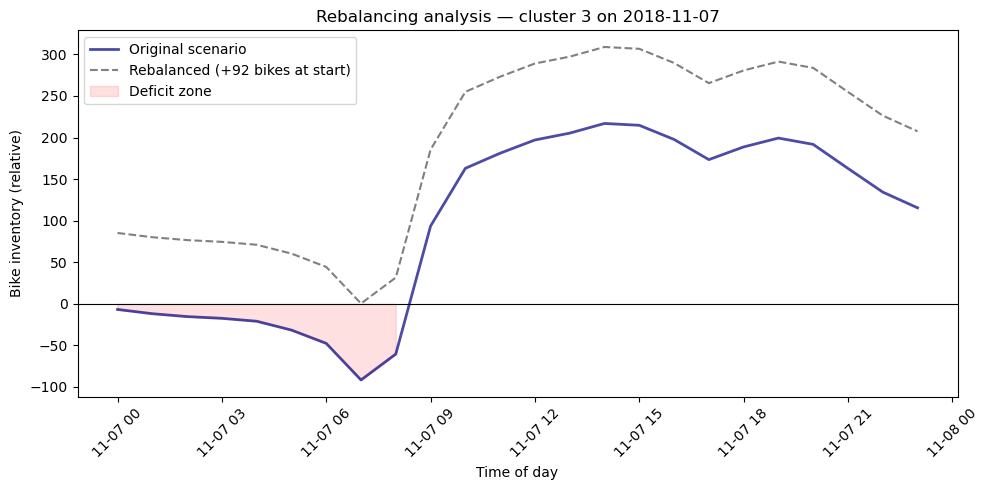

Cluster 3 on 2018-11-07
  Bikes needed to avoid deficits: 92


In [40]:
# Rebalancing analysis for top-demand cluster on a sample day
ANALYSIS_DAY = pd.Timestamp("2018-11-07")
TOP_CLUSTER = top_cluster if "top_cluster" in globals() else int(df_hourly.groupby("cluster_id")["pickups"].sum().idxmax())

def _cluster_day(pred_df: pd.DataFrame, cid: int, day: pd.Timestamp, colname: str) -> pd.DataFrame:
    mask = (pred_df["cluster_id"] == cid) & (pred_df["ts"].dt.floor("D") == day)
    series = (pred_df.loc[mask, ["ts", "y_hat"]]
                       .rename(columns={"y_hat": colname})
                       .set_index("ts"))
    hours = pd.date_range(day, periods=24, freq="H")
    return (series
            .reindex(hours)
            .fillna(0.0)
            .rename_axis("ts")
            .reset_index())

arrivals = _cluster_day(yhat_dropoffs_24, TOP_CLUSTER, ANALYSIS_DAY, "arrivals")
departures = _cluster_day(yhat_pickups_24, TOP_CLUSTER, ANALYSIS_DAY, "departures")

rebal = arrivals.merge(departures, on="ts", how="inner")
rebal["net_flow"] = rebal["arrivals"] - rebal["departures"]
rebal["cumulative"] = rebal["net_flow"].cumsum()

bikes_needed = int(np.ceil(max(0.0, -rebal["cumulative"].min())))
rebal["safe_inventory"] = rebal["cumulative"] + bikes_needed

plt.figure(figsize=(10, 5))
plt.plot(rebal["ts"], rebal["cumulative"], label="Original scenario", color="navy", linewidth=2, alpha=0.7)
plt.plot(rebal["ts"], rebal["safe_inventory"], label=f"Rebalanced (+{bikes_needed} bikes at start)", color="gray", linestyle="--", linewidth=1.5)
plt.axhline(0, color="black", linestyle="-", linewidth=0.8)
plt.fill_between(rebal["ts"], rebal["cumulative"], 0, where=rebal["cumulative"] < 0, color="red", alpha=0.12, label="Deficit zone")
plt.title(f"Rebalancing analysis — cluster {TOP_CLUSTER} on {ANALYSIS_DAY.date()}")
plt.ylabel("Bike inventory (relative)")
plt.xlabel("Time of day")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Cluster {TOP_CLUSTER} on {ANALYSIS_DAY.date()}")
print(f"  Bikes needed to avoid deficits: {bikes_needed}")


In [38]:
# Quick metrics snapshots for selected clusters/citywide
def compute_metrics(test_df, pred_df, target, cluster_ids=None):
    df = test_df[["ts","cluster_id",target]].merge(
        pred_df[["ts","cluster_id","y_hat"]],
        on=["ts","cluster_id"],
        how="inner",
    )
    if cluster_ids is not None:
        df = df[df["cluster_id"].isin(cluster_ids)]
    y = df[target].astype(float).to_numpy()
    yhat = df["y_hat"].astype(float).clip(lower=0).to_numpy()
    e = y - yhat
    mae = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    wape = float(np.sum(np.abs(e)) / max(1e-9, np.sum(y)))
    mape = float(np.mean(np.abs(e) / np.where(y == 0, 1e-9, y))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

print("Citywide pickups:", compute_metrics(test, yhat_pickups_24, "pickups"))
print("Citywide dropoffs:", compute_metrics(test, yhat_dropoffs_24, "dropoffs"))
print("Cluster 0 pickups:", compute_metrics(test, yhat_pickups_24, "pickups", [0]))
print("Cluster 6 pickups:", compute_metrics(test, yhat_pickups_24, "pickups", [6]))
print("Cluster 0 dropoffs:", compute_metrics(test, yhat_dropoffs_24, "dropoffs", [0]))
print("Cluster 6 dropoffs:", compute_metrics(test, yhat_dropoffs_24, "dropoffs", [6]))


Citywide pickups: {'MAE': 29.992605508715904, 'RMSE': 69.6172011749449, 'WAPE': 0.46287361225315254, 'MAPE_pct': 15100766983.821424}
Citywide dropoffs: {'MAE': 29.84478679020965, 'RMSE': 69.1192790692487, 'WAPE': 0.46054985643240803, 'MAPE_pct': 14856561888.612848}
Cluster 0 pickups: {'MAE': 12.074804549379845, 'RMSE': 17.64387530189174, 'WAPE': 0.43094865578479014, 'MAPE_pct': 18271144173.483047}
Cluster 6 pickups: {'MAE': 86.91031550659558, 'RMSE': 148.69342450574737, 'WAPE': 0.41117046987124234, 'MAPE_pct': 978077291.7171068}
Cluster 0 dropoffs: {'MAE': 12.675876923318897, 'RMSE': 18.474538137070684, 'WAPE': 0.4456113294690567, 'MAPE_pct': 20411492452.420753}
Cluster 6 dropoffs: {'MAE': 85.99741358307506, 'RMSE': 148.94012435934633, 'WAPE': 0.4065940250661138, 'MAPE_pct': 142.20337413717698}
